In [113]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [115]:
df = pd.read_csv('dataset_final.csv', parse_dates=True)
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2049 entries, 0 to 2048
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype                    
---  ------                --------------  -----                    
 0   datetime              2049 non-null   datetime64[ns, UTC+08:00]
 1   visibility            2049 non-null   float64                  
 2   Temperature           2049 non-null   float64                  
 3   Relative Temperature  2049 non-null   float64                  
 4   Min Temperature       2049 non-null   float64                  
 5   Max Temperature       2049 non-null   float64                  
 6   pressure              2049 non-null   float64                  
 7   humidity              2049 non-null   float64                  
 8   Wind Speed            2049 non-null   float64                  
 9   Cloudiness            2049 non-null   float64                  
 10  weather               2049 non-null   object                

In [116]:
df['hour'] = df['datetime'].dt.hour
df['day'] = df['datetime'].dt.day
df['weekday'] = df['datetime'].dt.weekday  # 0 = Monday
df['month'] = df['datetime'].dt.month
df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)
df['is_night'] = df['hour'].isin(list(range(0, 6)) + list(range(20, 24))).astype(int)

In [117]:
label_encoder = LabelEncoder()
df['weather_label'] = label_encoder.fit_transform(df['weather'])


In [118]:
df = df.sort_values('datetime')
print("Class distribution before split:")
print(df['weather_label'].value_counts())

Class distribution before split:
weather_label
1    1903
2      93
0      53
Name: count, dtype: int64


In [119]:
train_df = df[df['datetime'] < '2025-03-23']
test_df = df[df['datetime'] > '2025-03-28']

feature_cols = df.columns.difference(['datetime', 'weather', 'weather_label'])
X_train = train_df[feature_cols]
y_train = train_df['weather_label']
X_test = test_df[feature_cols]
y_test = test_df['weather_label']

In [120]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

In [125]:
svm_model = SVC(class_weight='balanced', probability=True, random_state=42)
svm_model.fit(X_train_bal, y_train_bal)

y_pred = svm_model.predict(X_test)


In [126]:
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Classification Report:
              precision    recall  f1-score   support

           0       0.01      1.00      0.01         4
           1       0.00      0.00      0.00       739
           2       0.75      0.22      0.34        27

    accuracy                           0.01       770
   macro avg       0.25      0.41      0.12       770
weighted avg       0.03      0.01      0.01       770



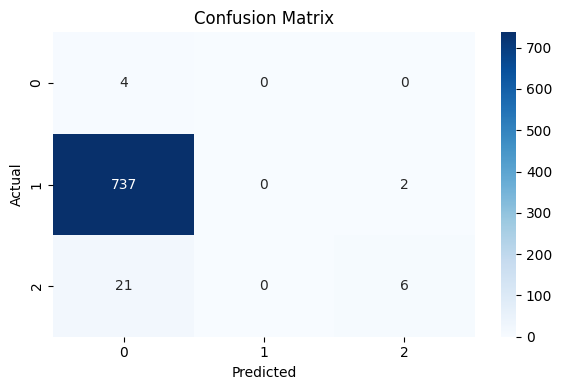

In [127]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

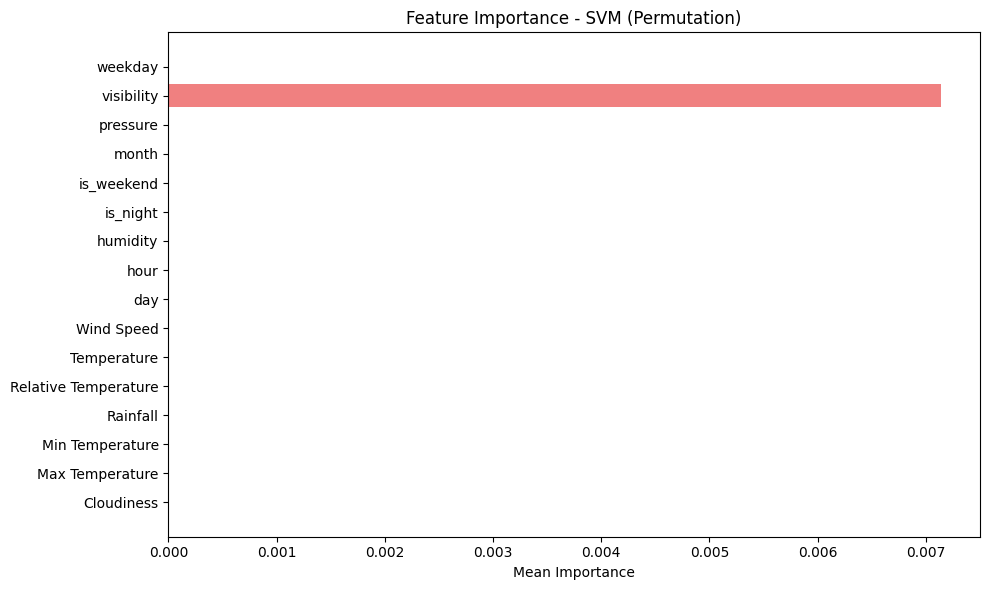

In [128]:
result = permutation_importance(svm_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
importances = result.importances_mean
feature_names = X_test.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color='lightcoral')
plt.xlabel('Mean Importance')
plt.title('Feature Importance - SVM (Permutation)')
plt.tight_layout()
plt.show()
